# Exploring Gender Biases in Word2Vec 

This notebook processes the data from the Gutenburg and Wikipedia datasets. Then, it trains the words agains Genism's word2Vec model, a custom skip-gram based word2vec model and our debiasing solutions. 

To measure biases that are hidden within these embeddings created by the models, we explore the direct bias, indirect bias, and the WEAT metric for comparision. 

In [1]:
#library imports
import string
import numpy as np
from numpy.linalg import norm
import json
import tempfile
from sklearn.decomposition import PCA
import torch
from torchtext.data.utils import get_tokenizer

#configure paths
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\nn_webserver")

#gutenberg data import
from gutenberg.gutenberg_data import get_urls, read_data_from_urls

#models import
from gensim.models import Word2Vec
from custom_word2vec import Custom_Word2Vec
import pickle

#plots
import matplotlib.pyplot as plt 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


## 1 - Data Preprocessing

In [2]:
def create_tokens(data):
    """
    creates tokenized list with puncuation and digits removed and lowercase words 

    :param data: list of strings
    :return: a list of tokens 
    """ 
    tokens = []
    for sentance in data:
        sentance = sentance.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
        sentance = sentance.translate(str.maketrans('', '', string.digits)) #remove digits
        tokenizer = get_tokenizer("basic_english", language="en") #remove unessasary characters, splits into spaces
        tokens.append(tokenizer(sentance))
  
    return tokens
  

**Gutenburg Dataset**

In [3]:
# Gutenburg
train_urls = get_urls('train')
train_data_g = read_data_from_urls(train_urls)
train_data_g=str(train_data_g).split('.')

rough_guten = create_tokens(train_data_g)

sentences_gutenburg = []
for sentence in rough_guten:
    new_sentence = []
    for word in sentence:
        if 'rn' in word:
            temp = word.replace('rn', ' ')
            while temp and temp[0] == ' ':
                temp = temp.replace(' ', '')
            while temp and '  ' in temp:
                temp = temp.replace('  ', '')
            if ' ' in temp:
                temp = temp.split(' ')
                for word_thing in temp:
                    new_sentence.append(word_thing)
            else:
                new_sentence.append(temp)
        else:
            new_sentence.append(word)
    sentences_gutenburg.append(new_sentence)

**Wikipedia Dataset**

In [ ]:
#Wikipedia
f = open('wikipedia-en-1000.json')
train_data_w = json.load(f)
train_data_w =str(train_data_w[0]).split('.')

sentences_wikipedia = create_tokens(train_data_w)
print(len(sentences_wikipedia))

159


## 2 - Genism Word2Vec

Using: Skip-gram training algorithm. 

Hyperparameters:
- min_freq: choosing the top N most frequent words - for easier training, weed out words that are irrelevant to us 
- size: embedding size. We use 300 as per Bolukbasi et al.
- window: the window used for looking at context and center words when traing the embeddings 

In [110]:
#hyperparameters
min_freq = 50
size = 300
window = 5
epochs = 11

**Gutenburg Genism Model**

In [111]:
model_g = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_g.init_weights()
model_g.build_vocab(sentences_gutenburg) 
model_g.train(sentences_gutenburg, total_examples=model_g.corpus_count, epochs=epochs)

model_g.save("models/model_g")


**Wikipedia Genism Model**

In [ ]:
model_w = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_w.init_weights()
model_w.build_vocab(sentences_wikipedia) 
model_w.train(sentences_wikipedia, total_examples=model_g.corpus_count, epochs=epochs)

model_w.save("models/model_w")

Now, save the embeddings to use in debiasing. 

In [112]:
with open('embeddings/gutenberg_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_g.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_g.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

In [ ]:
with open('embeddings/wikipedia_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_w.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_w.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

## 3 - Custom Word2Vec 

Using the same hyperparameters as Genism, train our own word2vec model (withought debiasing) on the data. 

In [20]:
# hyperparameters
embedding_dim=300
LR=0.01
window_size=2
EPOCHS=2
min_freq = 2000

**Gutenburg Custom Model**

Generating Skip Grams...
...(1.5466min)
Training. Curr Time = 16:16:00 , Estimated Finish Time = 21:10:06
Epoch: 1, Training Loss: 8491664.738260888  (100.6639min)
Epoch: 2, Training Loss: 8381964.123699829  (105.3134min)


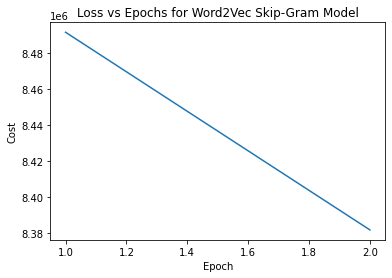

...(205.9882min)


In [22]:
model_g_custom = Custom_Word2Vec(sentences_gutenburg, embedding_dim, LR, window_size, EPOCHS, min_freq)
model_g_custom.train()



In [25]:
with open('models/model_g_custom', 'wb') as files:
    pickle.dump(model_g_custom, files)

Now, save the embeddings to use in debiasing.

In [27]:
with open('embeddings/gutenburg_custom_embeddings.txt', 'w') as f:
    for word in model_g_custom.corpus_vocab:
        embedding_str = [str(x) for x in model_g_custom.embedding(word)]
        embedding = ' '.join(embedding_str)
        f.write(word + " " + embedding +"\n")

### 3.1 - Savani et. al Debiasing 

In [2]:
#load
with open('models/model_g_custom' , 'rb') as f:
    model_g_custom = pickle.load(f)

In [3]:
#bias variables
model_g_custom.equalized_pairs = [["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"], ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"], ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"], ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"], ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"], ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]
model_g_custom.gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]

#hyperparameters
model_g_custom.pred_threshold=0.55
model_g_custom.epsilon=0.05
num_trails = 4
stddev = 0.5 #0.1
margin = 0.01
num_threshs = 50

#run debiasing 
model_g_custom.random_debiasing(num_trails, stddev, margin, num_threshs)

#save 
with open('models/model_g_custom_debiased', 'wb') as files:
    pickle.dump(model_g_custom, files)

with open('embeddings/gutenburg_custom_debiased_embeddings.txt', 'w') as f:
    for word in model_g_custom.corpus_vocab:
        embedding_str = [str(x) for x in model_g_custom.embedding(word)]
        embedding = ' '.join(embedding_str)
        f.write(word + " " + embedding +"\n")

Estimated time to complete:  5.133333333333334 h
finding best threshhold ...
1/4 sampled. Best objective so far: -0.30556901934939235 for threshold: 0.5918367346938775 ...(73.9692min)
finding best threshhold ...
2/4 sampled. Best objective so far: -0.30556901934939235 for threshold: 0.5918367346938775 ...(73.3584min)
finding best threshhold ...
3/4 sampled. Best objective so far: -0.30556901934939235 for threshold: 0.5918367346938775 ...(73.8759min)
finding best threshhold ...
4/4 sampled. Best objective so far: -0.30556901934939235 for threshold: 0.5918367346938775 ...(74.4021min)
Updating Model with best objective function results.


## 4 - Measuring Bias

### 4.0 - Define Helper functions

Define some useful helper functions to use in the measurement techniques

In [4]:
def get_vocab(model, model_type, vocab):
    '''
    returns the vocabulary of the model
    '''
    if model_type == 'genism' or model_type == 'wiki':
        return model.wv.key_to_index
    elif model_type == 'custom':
        return model.corpus_vocab.keys()
    elif model_type == 'debias':
        return vocab
    else:
        print("Model type is wrong")
        return []

def check_w_embedding(word_lists, model, printRemoved, model_type, vocab={}):
    '''
    checks if the embedding exists for the given word, and if not deletes it from the lists. 
    if printRemoved = true, it also declares the words that were not in the model embeddings. 
    '''
    new_w_lists = []
    
    for word_list in word_lists:
        new_w_l = []
        for w in word_list: 
            if w in get_vocab(model, model_type, vocab):
                new_w_l.append(w)
            else:
                if printRemoved:
                    print ("Word", w, " is not in the model")
        
        if (new_w_l):
            new_w_lists.append(new_w_l)
    
    return new_w_lists

def w_vec(word, model, model_type, vocab):
    '''
    returns the word embedding of the input word
    '''
    if model_type == 'genism' or model_type == 'wiki':
        return model.wv[word]
    elif model_type == 'custom':
        return model.embedding(word)
    elif model_type == 'debias':
        return vocab[word]
    else:
        print("Model type is wrong")
        return []

def cos_sim(a,b):
    '''
    returns the cosine similarity between 2 word embeddings 
    '''
    return np.dot(a, b)/(norm(a)*norm(b))

As well, for the debiased embeddings, we need a way to retrieve the dat from the embedding text file. Create a function to do so.

In [5]:
def read_debiased_embeddings(file):
    vocab = {}
    with open(file, 'r') as f:
        for line in f:
            key, embedding = line.split(' ', 1)#split by first space
            emb_vec= list(map(float, embedding.split(' ')[:-1])) #convert embedding to int, remove new line  
            vocab[key] = np.array(emb_vec)
    return vocab 

### 4.1 - Construct the g subspace
First, define gendered words and pairs ground truth (taken from Bolukbasi et al.) Using PCA, define the gendered subspace g, by taking the most prominent dimension. 

In [6]:
def filter_gender_pairs(gender_pairs):
    filtered_pairs=[]
    for pair in gender_pairs:
        if len(pair)==2:
            filtered_pairs.append(pair)
    return filtered_pairs

def gender_subspace_matrix(model, gender_pairs, model_type, vocab):
    '''
    create matrix of the gender space using gender pairs
        
    '''
    word_directions = []
    for word_pair in gender_pairs:
        if (len(word_pair) == 2):
            f_word = w_vec(word_pair[0], model, model_type, vocab)
            m_word = w_vec(word_pair[1], model, model_type, vocab)
            dif = f_word-m_word
            word_directions.append(dif)
        
        
    return np.array(word_directions)


def define_vector_g(model, model_type, gender_pairs, vocab={}):
    word_directions = gender_subspace_matrix(model, gender_pairs, model_type, vocab) 

    #PCA of word direction
    pca = PCA(n_components=len(gender_pairs))
    pca.fit(word_directions)
    
    ratios = pca.explained_variance_ratio_
    #print graph of PCA dimensions to determine how many dimensions should be kept
    print("PCA variance ratio:", ratios)
    print("PCA singular values:", pca.singular_values_)

    #use the 1 most prominent dimension
    pca = PCA(n_components=1)
    pca.fit(word_directions)
    g = pca.components_
    
    return g, ratios

def run_gender_subspace_calcs(model, model_type, txtfiles, custom= False):
    variance_ratios = []
    i = 0
    #genism model
    if (model_type == 'genism' or model_type == 'custom'):
        print ("---------Original-------------")
        gender_pairs_new = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, model_type))
        print ("Gender Pairs: ", gender_pairs_new)
        g, pca_ratios = define_vector_g(model, model_type, gender_pairs_new)
        variance_ratios.append(pca_ratios)
    
    #wiki model
    if (model_type == 'wiki'):
        print ("---------Original-------------")
        vocab = read_debiased_embeddings("embeddings/wikipedia_embeddings.txt")
        gender_pairs_wiki = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, 'debias', vocab))
        print ("Gender Pairs: ", gender_pairs_wiki)
        g, pca_ratios_wiki = define_vector_g(model, 'debias', gender_pairs_wiki, vocab)
        variance_ratios.append(pca_ratios_wiki)

    #2016 debiasing 
    if (not custom):
        print ("---------2016debias-------------")
        vocab2016 = read_debiased_embeddings(txtfiles[i])
        gender_pairs_2016 = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, 'debias', vocab2016))
        print ("Gender Pairs: ", gender_pairs_2016)
        g_2016, pca_ratios_2016 = define_vector_g(model, 'debias', gender_pairs_2016, vocab2016)
        variance_ratios.append(pca_ratios_2016)
        i+=1
    
    #2018 debiasing
    print ("---------2018debias-------------")
    vocab2018 = read_debiased_embeddings(txtfiles[i])
    gender_pairs_2018 = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, 'debias', vocab2018))
    print ("Gender Pairs: ", gender_pairs_2018)
    g_2018, pca_ratios_2018 = define_vector_g(model, 'debias', gender_pairs_2018, vocab2018)
    variance_ratios.append(pca_ratios_2018)
    i+=1
    
    #2020 debiasing
    if custom:
        print ("---------2020debias-------------")
        vocab2020 = read_debiased_embeddings(txtfiles[i])
        gender_pairs_2020 = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, 'debias', vocab2020))
        print ("Gender Pairs: ", gender_pairs_2020)
        g_2020, pca_ratios_2020 = define_vector_g(model, 'debias', gender_pairs_2020, vocab2020)
        variance_ratios.append(pca_ratios_2020)
    
    #combined graph:
    colors = ['orange', 'red', 'blue']
    if custom:
        labels = ['Original', '2018 Debiasing', '2020 Debiasing']
        plot_significance(variance_ratios, labels, colors, model_type, 0.05)
        return g, g_2018, g_2020
    else:
        labels = ['Original', '2016 Debiasing', '2018 Debiasing']
        plot_significance(variance_ratios, labels, colors, model_type, 0.3)

        return g, g_2016, g_2018

def plot_significance(variance_ratios, labels, colors, model, width):
    for i in range(len(variance_ratios)):
        ratio = variance_ratios[i]
        r = np.arange(1, len(ratio)+1)
        plt.bar(r + width*i, ratio, color=colors[i], edgecolor='white', width=width, alpha=0.5)
        plt.xlabel("Matrix Variance Column")
        plt.ylabel("Variance")
    
    
    plt.title("Significance of each eigenvector for "+model+" models") 
    plt.legend(labels)
    plt.show()
        

#gender pairs
gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]

**Gender Subspace for Gutenburg Models**

---------Original-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [2.2873145e-01 2.1048002e-01 1.6368133e-01 1.5716054e-01 1.3005719e-01
 7.5725868e-02 3.4163605e-02 6.6469462e-15]
PCA singular values: [4.0653491e+00 3.8997819e+00 3.4390182e+00 3.3698196e+00 3.0655053e+00
 2.3391445e+00 1.5711467e+00 6.9302035e-07]
---------2016debias-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [1.00000000e+00 1.43942143e-13 1.15199127e-13 9.53962115e-14
 8.43057607e-14 7.05038773e-14 4.84020684e-14 1.05201890e-30]
PCA singular values: [2.59396303e-01 9.84141992e-08 8.80416912e-08 8.01178610e-08
 7.53168950e-08 6.88763751e-08 5.70684060e-08 2.66057529e-16]
---------2018debias-------------
Gender 

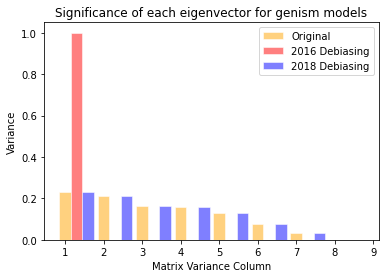

In [8]:
#load model
model_g = Word2Vec.load("models/model_g")

#calculate g subspace
g_gutenburg, g_gutenburg_2016, g_gutenburg_2018 = run_gender_subspace_calcs(model_g, "genism", ["2016debias/2016debias_gutenberg_emb.txt", "2018debias/2018debias_gutenberg_emb.txt"])

**Gender Subspace for Wikipedia Models**

---------Original-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['gal', 'guy'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [4.69855152e-01 2.05261717e-01 9.92370393e-02 7.70452044e-02
 7.30826804e-02 3.46785969e-02 3.17338090e-02 9.10580083e-03
 8.58932749e-33]
PCA singular values: [4.42402561e+00 2.92408246e+00 2.03316458e+00 1.79146547e+00
 1.74478882e+00 1.20189463e+00 1.14973231e+00 6.15878026e-01
 5.98157038e-16]
---------2016debias-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['gal', 'guy'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [9.38413057e-01 6.15869430e-02 6.30960885e-15 3.05790866e-15
 2.70274064e-15 2.53520595e-15 2.09857069e-15 1.88229480e-15
 4.09255393e-32]
PCA singular values: [1.14774681e+00 2.94031186e-01 9.41131459e-08 6.55181048e-08
 6.159

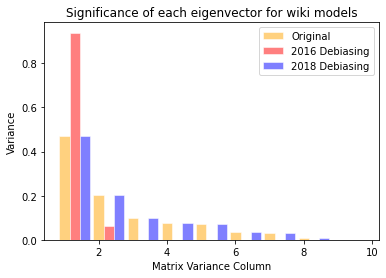

In [9]:
#calculate g subspace
g_wiki, g_wiki_2016, g_wiki_2018 = run_gender_subspace_calcs(model_g, "wiki", ["2016debias/2016debias_wiki_emb.txt", "2018debias/2018debias_wiki_emb.txt"])

**Gender Subspace for Gutenburg Custom Word2vec Models**

In [7]:
with open('models/model_g_custom' , 'rb') as f:
    model_g_custom = pickle.load(f)

---------Original-------------
Gender Pairs:  [['she', 'he'], ['her', 'his']]
PCA variance ratio: [1.0000000e+00 2.7546131e-14]
PCA singular values: [2.5387967e-01 4.2136477e-08]
---------2018debias-------------
Gender Pairs:  [['she', 'he'], ['her', 'his']]
PCA variance ratio: [1.00000000e+00 5.32367293e-32]
PCA singular values: [2.66063398e-01 6.13890364e-17]
---------2020debias-------------
Gender Pairs:  [['she', 'he'], ['her', 'his']]
PCA variance ratio: [1.00000000e+00 5.01568289e-32]
PCA singular values: [6.04471203e-01 1.35375680e-16]


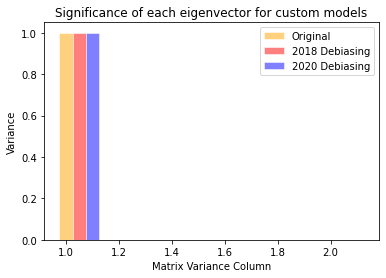

In [14]:
g_gutenburg_custom, g_gutenburg_2018_custom, g_gutenburg_2020_custom = run_gender_subspace_calcs(model_g_custom, "custom", ["2018debias/2018debias_gutenberg_emb_custom.txt", "embeddings/gutenburg_custom_debiased_embeddings.txt"], True)

### 4.2 - Direct Bias

To measure direct bias, we will be using the equation from Bolukbasi et al. shown below. 

<img src="img/Direct_Bias.png" style="width:300px;float:left;"/>

We will use the same gender neutral words that have been collected from the paper which is 
denoted by N. As well, we will utilize the paper’s gender directions (vector from one word to another) 
which were verified by crowdsourcing. The gender subspace g will be the unit vector g that captures the
gender directions, computed by principal components in the paper. Finally, we will consider c, which is the 
strictness of bias, as a hyperparameter in our experiment. 

In [9]:
def calculate_direct_metric(gendered_word_set, model, c, g, model_type, vocab={}):
    '''
    calculate the direct bias using Bolukbasi et al.'s equation
    '''
    cosine_add = 0
    for word in gendered_word_set:
        cosine_add += np.abs(cos_sim(w_vec(word, model, model_type, vocab),g[0]))**c
    
    return cosine_add/len(gendered_word_set)
    

c = 1 #hyperparameter

gendered_words = 'engineer, professor, intelligent, teacher, police, nurture, captain, writer, poet, scientist, lawyer, receptionist, nurture, firefighter, doctor, nurse, manager, business, leader, follower, work, read, actress, home, sport, soccer, basketball, baseball, hockey, coach'
gendered_words = gendered_words.split(", ")

**Direct Metric for Gutenburg Models**

In [16]:
#load models
model_g = Word2Vec.load("models/model_g")

#genism
gendered_word_set = check_w_embedding([gendered_words], model_g, False, 'genism')[0]
print("Direct metric gutenburg:", calculate_direct_metric(gendered_word_set, model_g, c, g_gutenburg, 'genism'))

#2016 debiasing 
vocab2016 = read_debiased_embeddings('2016debias/2016debias_gutenberg_emb.txt')
gendered_word_set_2016 = check_w_embedding([gendered_words], model_g, False, 'debias', vocab2016)[0]
print("Direct metric gutenburg 2016 debias:", calculate_direct_metric(gendered_word_set_2016, model_g, c, g_gutenburg_2016, 'debias', vocab2016))

#2018 debiasing
vocab2018 = read_debiased_embeddings('2018debias/2018debias_gutenberg_emb.txt')
gendered_word_set_2018 = check_w_embedding([gendered_words], model_g, False, 'debias', vocab2018)[0]
print("Direct metric gutenburg 2018 debias:", calculate_direct_metric(gendered_word_set_2018, model_g, c, g_gutenburg_2018, 'debias', vocab2018))


Direct metric gutenburg: 0.05162829257460544
Direct metric gutenburg 2016 debias: 3.562400578130557e-08
Direct metric gutenburg 2018 debias: 0.05132398197252487


**Direct Metric for Wikipedia Models**

In [21]:
#wiki
vocab = read_debiased_embeddings("embeddings/wikipedia_embeddings.txt")
gendered_word_set = check_w_embedding([gendered_words], model_g, False, 'debias', vocab)[0]
print("Direct metric wiki:", calculate_direct_metric(gendered_word_set, model_g, c, g_wiki, 'debias', vocab))

#2016 debiasing 
vocab2016 = read_debiased_embeddings('2016debias/2016debias_wiki_emb.txt')
gendered_word_set_2016 = check_w_embedding([gendered_words], model_g, False, 'debias', vocab2016)[0]
print("Direct metric wiki 2016 debias:", calculate_direct_metric(gendered_word_set_2016, model_g, c, g_wiki_2016, 'debias', vocab2016))

#2018 debiasing
vocab2018 = read_debiased_embeddings('2018debias/2018debias_wiki_emb.txt')
gendered_word_set_2018 = check_w_embedding([gendered_words], model_g, False, 'debias', vocab2018)[0]
print("Direct metric wiki 2018 debias:", calculate_direct_metric(gendered_word_set_2018, model_g, c, g_wiki_2018, 'debias', vocab2018))

Direct metric wiki: 0.06087632697703697
Direct metric wiki 2016 debias: 0.07916512143350311
Direct metric wiki 2018 debias: 0.060161984061677866


**Direct Metric for Gutenburg Custom Word2vec Models**

In [12]:
#load models
with open('models/model_g_custom' , 'rb') as f:
    model_g_custom = pickle.load(f)

In [15]:
#create new word set that the model includes
gendered_words = 'earth, get, place, heart, night, nothing, heard, thought, give, people, life, old, children, face, first, land, make, things, time, love, great'
gendered_words = gendered_words.split(", ")

#original
gendered_word_set = check_w_embedding([gendered_words], model_g_custom, False, 'custom')[0]
print("Direct metric gutenburg:", calculate_direct_metric(gendered_word_set, model_g_custom, c, g_gutenburg_custom, 'custom'))

#2018 debiasing
vocab2018 = read_debiased_embeddings('2018debias/2018debias_gutenberg_emb_custom.txt')
gendered_word_set_2018 = check_w_embedding([gendered_words], model_g_custom, False, 'debias', vocab2018)[0]
print("Direct metric gutenburg 2018 debias:", calculate_direct_metric(gendered_word_set_2018, model_g_custom, c, g_gutenburg_2018_custom, 'debias', vocab2018))

#2020 debiasing
vocab2020 = read_debiased_embeddings('embeddings/gutenburg_custom_debiased_embeddings.txt')
gendered_word_set_2020 = check_w_embedding([gendered_words], model_g_custom, False, 'debias', vocab2020)[0]
print("Direct metric gutenburg 2020 debias:", calculate_direct_metric(gendered_word_set_2020, model_g_custom, c, g_gutenburg_2020_custom, 'debias', vocab2020))


Direct metric gutenburg: 0.19221440580995044
Direct metric gutenburg 2018 debias: 0.32718988855668013
Direct metric gutenburg 2020 debias: 0.3601605396326931


### 4.3 - Indirect Bias

To measure indirect bias, we will be using the equation from Bolukbasi et al. shown below.

<img src="img/Indirect_Bias.png" style="width:300px;float:left;"/>

$w_{\perp}$ is defined as $w_{\perp} = w - w_{g}$ where $w_{g}=(w*g)*g$ as mentioned in the paper. We will be using the g subspace calculated above. As for the word pairs, we will run a few experiments. The first will be the most extreme words in the softball-football direction as mentioned in the paper. 

In [16]:
def calculate_indirect_metric(g, w, v):
    wg = np.dot(np.dot(w,g[0]),g[0])
    vg = np.dot(np.dot(v,g[0]),g[0])
    w_norm_vec = w-wg
    v_norm_vec = v-vg
    w_norm = norm(w_norm_vec)
    v_norm = norm(v_norm_vec)
    
    return (np.dot(w,v) - np.dot(w_norm_vec,v_norm_vec)/(w_norm*v_norm))/np.dot(w,v)

def compare_indirect_metrics(words, c_word, model,g, model_type, vocab={}):
    metrics=[]
    for w in words:
        metrics.append(calculate_indirect_metric(g, w_vec(c_word,model, model_type, vocab), w_vec(w,model, model_type, vocab)))
    
    return metrics

def plot_indirect_metric(words, w, m, model, g_values, model_type, labels, txtfiles, colors):
    fig, ax = plt.subplots(1,1) 
    
    idx=0
    for i in range(len(labels)):
        b_vals_w = []
        b_vals_m = []

        #calculate indirect beta values
        if labels[i] == "Original": #first iteration model
            b_vals_w = compare_indirect_metrics(words, w, model, g_values[i], model_type)
            b_vals_m = compare_indirect_metrics(words, m, model, g_values[i], model_type)
        else:
            vocab = read_debiased_embeddings(txtfiles[idx])
            b_vals_w = compare_indirect_metrics(words, w, model, g_values[i], "debias", vocab)
            b_vals_m = compare_indirect_metrics(words, m, model, g_values[i], "debias", vocab)
            idx+=1
            
        print("b_vals_w:", b_vals_w)
        print("b_vals_m:", b_vals_m)
        #plot
        ax.plot(range(1, len(words)+1), b_vals_w, marker='o', color = colors[i], alpha=0.8)
        ax.plot(range(1, len(words)+1), b_vals_m, '--', marker='o', color = colors[i], alpha=0.8)
        

    ax.set_xticks(range(1, len(words_w)+1))
    ax.set_xticklabels(words, rotation='horizontal', fontsize=10)
    plt.ylabel('β values')
    plt.xlabel('non-related words')
    plt.title('Indirect metrics for '+ model_type+ " models")
    
    legend_labels =[]
    for l in labels:
        legend_labels.append(w + " - "+ l)
        legend_labels.append(m + " - "+ l)
        
    ax.legend(legend_labels, bbox_to_anchor=(1.04,1))
    plt.show()
    
#Experiment- recreate Bolukbasi et al.'s experiement but with words available in the datasetss
words_w= ['beauty', 'fashion', 'marriage', 'charm', 'nurse'] 
w = 'clean' 
words_m = ['paper', 'money', 'office', 'police', 'strength'] 
m = 'build'

**Indirect Metric for Gutenburg Models**

0
b_vals_w: [0.95366323, 0.92422444, 0.9415778, 0.9205797, 1.3884088]
b_vals_m: [0.9389032, 0.92986566, 0.939495, 0.9270366, 0.93395746]
1


ValueError: shapes (299,) and (300,) not aligned: 299 (dim 0) != 300 (dim 0)

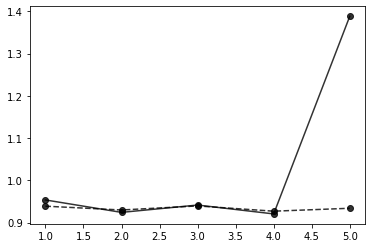

In [39]:
#load models
model_g = Word2Vec.load("models/model_g")

#check that all models contain the experiment words
words_w, words_m, [w, m] = check_w_embedding([words_w, words_m, [w, m]], model_g, True, 'genism')

#female correlated words
plot_indirect_metric(words_w, w, m, model_g, [g_gutenburg, g_gutenburg_2016, g_gutenburg_2018], 'genism', ['Original', '2016 Debiasing','2018 Debiasing'], ["2016debias/2016debias_gutenberg_emb.txt", "2018debias/2018debias_gutenberg_emb.txt"], ["Black", "Red", "Orange"])

#male correlated words
plot_indirect_metric(words_m, w, m, model_g, [g_gutenburg, g_gutenburg_2016, g_gutenburg_2018], 'genism', ['Original', '2016 Debiasing', '2018 Debiasing'], ["2016debias/2016debias_gutenberg_emb.txt", "2018debias/2018debias_gutenberg_emb.txt"], ["Blue", "Green", "Black"])


**Indirect Metric for Wikipedia Models**

b_vals_w: [0.9177660993818735, 0.9131136826158803, 0.8933444026818028, 0.9165408283011843, 0.9113092831994486]
b_vals_m: [0.9102605897449744, 0.9063730471878055, 0.9086640325291999, 0.9085827466805928, 0.9051157100611188]
b_vals_w: [-0.07045461146361738, -0.07011703478791004, -0.2740862614633388, -0.04918387683733056, -0.08179905446836867]
b_vals_m: [-0.022915297929084165, -0.02568703540829599, -0.04566430692170285, -0.013686863572700096, -0.028581457005098763]
b_vals_w: [0.9172591527180699, 0.9133586059972365, 0.8883433758321103, 0.915970275737369, 0.9111425886653836]
b_vals_m: [0.9095022631022676, 0.9062884057890864, 0.9073636678533832, 0.9082947761641381, 0.9046372783093519]


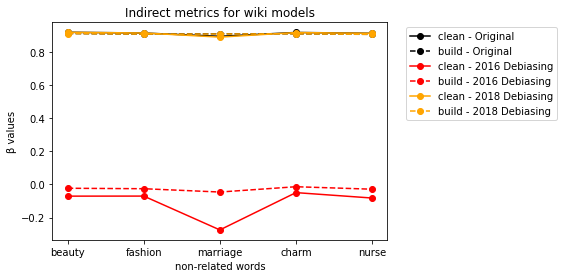

b_vals_w: [0.900171212079532, 0.9112466979991007, 0.9095757466580241, 0.9201485248023188, 0.9205921959504701]
b_vals_m: [0.8868281513751737, 0.89709598280727, 0.9006454734479988, 0.9049215264656607, 0.902964799357083]
b_vals_w: [-0.014137726149974683, 0.002430457911871474, -0.042321342000190186, 0.022591716662459585, 0.027417030713376516]
b_vals_m: [-0.003371409415445644, 0.0007684864639188525, -0.011372901486820148, 0.009452943736959549, 0.0020927886750363835]
b_vals_w: [0.8999307654829759, 0.9107883376751048, 0.9090135009934405, 0.9189871492854033, 0.9200029186533365]
b_vals_m: [0.8876519416961742, 0.896979084465571, 0.9004582296997949, 0.9051296712700476, 0.9030096144199221]


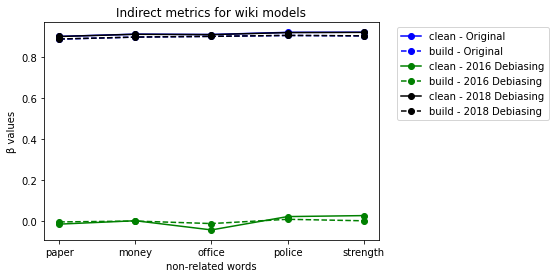

In [60]:
#load models
model_g = Word2Vec.load("models/model_g")

#check that all models contain the experiment words
words_w, words_m, [w, m] = check_w_embedding([words_w, words_m, [w, m]], model_g, True, 'genism')

#female correlated words
plot_indirect_metric(words_w, w, m, model_g, [g_wiki, g_wiki_2016, g_wiki_2018], 'wiki', ['Original', '2016 Debiasing','2018 Debiasing'], ["embeddings/wikipedia_embeddings.txt", "2016debias/2016debias_wiki_emb.txt", "2018debias/2018debias_wiki_emb.txt"], ["Black", "Red", "Orange"])

#male correlated words
plot_indirect_metric(words_m, w, m, model_g, [g_wiki, g_wiki_2016, g_wiki_2018], 'wiki', ['Original', '2016 Debiasing', '2018 Debiasing'], ["embeddings/wikipedia_embeddings.txt", "2016debias/2016debias_wiki_emb.txt", "2018debias/2018debias_wiki_emb.txt"], ["Blue", "Green", "Black"])

**Indirect Metric for Gutenburg Custom Word2vec Models**

In [ ]:
#load models
with open('models/model_g_custom' , 'rb') as f:
    model_g_custom = pickle.load(f)

{'the': 1, '': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'i': 7, 'in': 8, 'that': 9, 'he': 10, 'it': 11, 'for': 12, 'with': 13, 'his': 14, 'is': 15, 'you': 16, 'was': 17, 'my': 18, 'not': 19, 'as': 20, 'be': 21, 'but': 22, 'me': 23, 'him': 24, 'this': 25, 'have': 26, 'all': 27, 'on': 28, 'they': 29, 'had': 30, 'by': 31, 'at': 32, 'from': 33, 'which': 34, 'shall': 35, 'her': 36, 'so': 37, 'thou': 38, 'them': 39, 'are': 40, 'will': 41, 'we': 42, 'your': 43, 'were': 44, 'one': 45, 'their': 46, 'lord': 47, 'no': 48, 'what': 49, 'or': 50, 'if': 51, 'there': 52, 'when': 53, 'she': 54, 'unto': 55, 'out': 56, 'said': 57, 'thy': 58, 'an': 59, 'then': 60, 'up': 61, 'who': 62, 'do': 63, 'thee': 64, 'now': 65, 'upon': 66, 'man': 67, 'our': 68, 'would': 69, 'more': 70, 'come': 71, 'into': 72, 'us': 73, 'god': 74, 'like': 75, 'been': 76, 'good': 77, 'well': 78, 'than': 79, 'some': 80, 'go': 81, 'how': 82, 'king': 83, 'time': 84, 'did': 85, 'let': 86, 'may': 87, 'down': 88, 'made': 89, 'sir': 90, 'befor

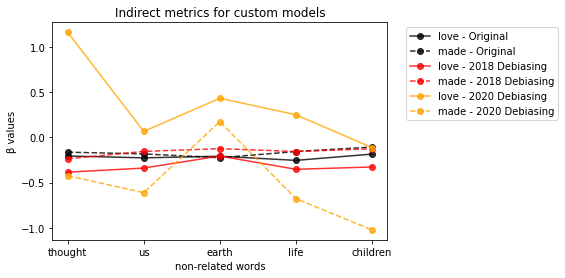

idx:  0
b_vals_w: [-0.35634068, -0.24419995, -0.200305, -0.23023446, -0.26424268]
b_vals_m: [-0.2786826, -0.19388175, -0.16708761, -0.14783718, -0.24191758]
idx:  0
b_vals_w: [-0.522048508860144, -0.3797493213473631, -0.2173737811038662, -0.5849750567054489, -0.38954862606155033]
b_vals_m: [-0.27376747241391697, -0.19944493287564585, -0.15606170954776383, -0.34783819970234914, -0.28622927296647965]
idx:  1
b_vals_w: [0.464295449386145, 1.4701106376635986, 0.30045382435950674, 0.06344396895896799, -0.15223863353229514]
b_vals_m: [-1.0862970364449747, 0.23991086466174685, -0.7972430729289277, -0.7073109900837466, -0.8779247318684991]


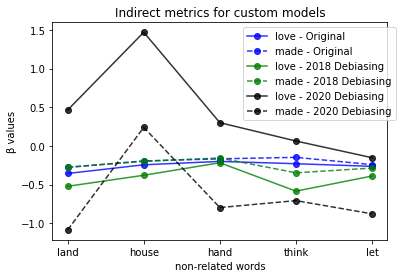

In [67]:
print(model_g_custom.corpus_vocab)
#check that all models contain the experiment words
words_w= ['thought', 'us', 'earth', 'life', 'children'] 
w = 'love' 
words_m = ['land', 'house', 'hand', 'think', 'let'] 
m = 'made'
words_w, words_m, [w, m] = check_w_embedding([words_w, words_m, [w, m]], model_g_custom, True, 'custom')

#female correlated words
plot_indirect_metric(words_w, w, m, model_g_custom, [g_gutenburg_custom, g_gutenburg_2018_custom, g_gutenburg_2020_custom], 'custom', ['Original','2018 Debiasing', '2020 Debiasing'], ["2018debias/2018debias_gutenberg_emb_custom.txt", "embeddings/gutenburg_custom_debiased_embeddings.txt"], ["Black", "Red", "Orange"])

#male correlated words
plot_indirect_metric(words_m, w, m, model_g_custom, [g_gutenburg_custom, g_gutenburg_2018_custom, g_gutenburg_2020_custom], 'custom', ['Original', '2018 Debiasing', '2020 Debiasing'], ["2018debias/2018debias_gutenberg_emb_custom.txt", "embeddings/gutenburg_custom_debiased_embeddings.txt"], ["Blue", "Green", "Black"])

### 4.4 - WEAT Metric

To measure WEAT, we used the formula defined in Caliskan et al., which is an additional direct bias measure. 

<img src="img/WEAT.png" style="width:300px;float:left;"/>

In [72]:
def s_word_A_B(w,A,B,model, model_type, vocab):
    mean_A_sum = 0
    mean_B_sum = 0
    w_v = w_vec(w,model, model_type, vocab)
    
    for a in A:
        a_vec = w_vec(a,model, model_type, vocab)
        mean_A_sum +=cos_sim(w_v,a_vec)
    
    for b in B:
        b_vec = w_vec(b,model, model_type, vocab)
        mean_B_sum +=cos_sim(w_v,b_vec)
        
    return mean_A_sum/len(A) - mean_B_sum/len(B)

def s_X_Y_A_B(X,Y,A,B,model, model_type, vocab={}):
    sum_X = 0
    sum_Y = 0
    
    for x in X:
        sum_X += s_word_A_B(x,A,B,model, model_type, vocab)
        
    for y in Y:
        sum_Y += s_word_A_B(y,A,B,model, model_type, vocab)
    
    return sum_X - sum_Y

Now, lets run experiments on the models <br>
A and B are the attribute word groups (8 words each), and X,Y are the target words

In [69]:
#Experiment 1 - work/family
A = ['tie', 'manage', 'work', 'paper', 'money', 'office', 'business', 'meeting']
B = ['home', 'parents', 'children', 'family', 'sister', 'marriage', 'charm', 'clean']
X = ['he', 'him']
Y = ['she', 'her'] 

#Experiment 2 - professions
A_2 = ['police', 'manage', 'business', 'lawyer', 'officer', 'science', 'build', 'fire']
B_2 = ['teacher', 'clean', 'social', 'hair', 'art', 'make', 'writer', 'library'] 


**WEAT Metric for Gutenburg Models**

In [16]:
#load models
model_g = Word2Vec.load("models/model_g")

print ("---------Genism-------------")
A_g,B_g,X_g,Y_g,A_2_g,B_2_g = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'genism')
print ("WEAT Exp 1:", s_X_Y_A_B(X_g,Y_g,A_g,B_g,model_g, 'genism'))
print ("WEAT Exp 2:", s_X_Y_A_B(X_g,Y_g,A_2_g,B_2_g,model_g, 'genism'))

print ("---------2016 Debiasing-------------")
vocab2016 = read_debiased_embeddings("2016debias/2016debias_gutenberg_emb.txt")
A_g_2016,B_g_2016,X_g_2016,Y_g_2016,A_2_g_2016,B_2_g_2016 = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'debias', vocab2016)
print ("WEAT Exp 1:", s_X_Y_A_B(X_g_2016,Y_g_2016,A_g_2016,B_g_2016,model_g, 'debias', vocab2016))
print ("WEAT Exp 2:", s_X_Y_A_B(X_g_2016,Y_g_2016,A_2_g_2016,B_2_g_2016,model_g, 'debias', vocab2016))

print ("---------2018 Debiasing-------------")
vocab2018 = read_debiased_embeddings("2018debias/2018debias_gutenberg_emb.txt")
A_g_2018,B_g_2018,X_g_2018,Y_g_2018,A_2_g_2018,B_2_g_2018 = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'debias', vocab2018)
print ("WEAT Exp 1:", s_X_Y_A_B(X_g_2018,Y_g_2018,A_g_2018,B_g_2018,model_g, 'debias', vocab2018))
print ("WEAT Exp 2:", s_X_Y_A_B(X_g_2018,Y_g_2018,A_2_g_2018,B_2_g_2018,model_g, 'debias', vocab2018))


---------Genism-------------
WEAT Exp 1: 0.17949908575974405
WEAT Exp 2: 0.09589393716305494
---------2016 Debiasing-------------
WEAT Exp 1: 0.12776186359061337
WEAT Exp 2: 0.05573103428929263
---------2018 Debiasing-------------
WEAT Exp 1: 0.15221834486977004
WEAT Exp 2: 0.09102151140409755


**WEAT Metric for Wikipedia Models**

In [52]:
print ("---------Genism-------------")
vocab = read_debiased_embeddings("embeddings/wikipedia_embeddings.txt")
A_w,B_w,X_w,Y_w,A_2_w,B_2_w = check_w_embedding([A,B,X,Y,A_2,B_2], model_g, True, 'debias', vocab)
print ("WEAT Exp 1:", s_X_Y_A_B(X_w,Y_w,A_w,B_w,model_g, 'wiki'))
print ("WEAT Exp 2:", s_X_Y_A_B(X_w,Y_w,A_2_w,B_2_w,model_g, 'wiki'))

print ("---------2016 Debiasing-------------")
vocab2016 = read_debiased_embeddings("2016debias/2016debias_wiki_emb.txt")
A_w_2016,B_w_2016,X_w_2016,Y_w_2016,A_2_w_2016,B_2_w_2016 = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'debias', vocab2016)
print ("WEAT Exp 1:", s_X_Y_A_B(X_w_2016,Y_w_2016,A_w_2016,B_w_2016,model_g, 'debias', vocab2016))
print ("WEAT Exp 2:", s_X_Y_A_B(X_w_2016,Y_w_2016,A_2_w_2016,B_2_w_2016,model_g, 'debias', vocab2016))

print ("---------2018 Debiasing-------------")
vocab2018 = read_debiased_embeddings("2018debias/2018debias_wiki_emb.txt")
A_w_2018,B_w_2018,X_w_2018,Y_w_2018,A_2_w_2018,B_2_w_2018 = check_w_embedding([A,B,X,Y,A_2,B_2], model_g, True, 'debias', vocab2018)
print ("WEAT Exp 1:", s_X_Y_A_B(X_w_2018,Y_w_2018,A_w_2018,B_w,model_g, 'debias', vocab2018))
print ("WEAT Exp 2:", s_X_Y_A_B(X_w_2018,Y_w_2018,A_2_w_2018,B_2_w_2018,model_g, 'debias', vocab2018))


---------Genism-------------
WEAT Exp 1: 0.20446737622842193
WEAT Exp 2: 0.12759239319711924
---------2016 Debiasing-------------
WEAT Exp 1: 0.06078536076618002
WEAT Exp 2: 0.028830618939882563
---------2018 Debiasing-------------
WEAT Exp 1: 0.11953439139491051
WEAT Exp 2: 0.05835008333097039


**WEAT Metric for Gutenburg Custom Word2vec Models**

In [ ]:
#load models
with open('models/model_g_custom' , 'rb') as f:
    model_g_custom = pickle.load(f)

In [75]:
#Experiment 3 - custom model words
A_3 = ['land', 'house', 'hand', 'think', 'make', 'made', 'days', 'among']
B_3 = ['us', 'earth', 'life', 'children', 'art', 'love', 'face', 'hear'] 
    
    
print ("---------Original-------------")
X_g,Y_g,A_3_g,B_3_g = check_w_embedding([X,Y, A_3,B_3], model_g_custom, True, 'custom')
print ("WEAT Exp 3:", s_X_Y_A_B(X_g,Y_g,A_3_g,B_3_g,model_g_custom, 'custom'))

print ("---------2018 Debiasing-------------")
vocab2018 = read_debiased_embeddings("2018debias/2018debias_gutenberg_emb_custom.txt")
X_g_2018,Y_g_2018,A_3_g_2018,B_3_g_2018 = check_w_embedding([X,Y, A_3,B_3], model_g_custom, True, 'debias', vocab2018)
print ("WEAT Exp 3:", s_X_Y_A_B(X_g_2018,Y_g_2018,A_3_g_2018,B_3_g_2018,model_g_custom, 'debias', vocab2018))

print ("---------2020 Debiasing-------------")
vocab2020 = read_debiased_embeddings("embeddings/gutenburg_custom_debiased_embeddings.txt")
X_g_2020,Y_g_2020,A_3_g_2020,B_3_g_2020 = check_w_embedding([X,Y, A_3,B_3], model_g_custom, True, 'debias', vocab2020)
print ("WEAT Exp 3:", s_X_Y_A_B(X_g_2020,Y_g_2020,A_3_g_2020,B_3_g_2020,model_g_custom, 'debias', vocab2020))

---------Original-------------
WEAT Exp 3: -0.06276037381030619
---------2018 Debiasing-------------
WEAT Exp 3: 0.00021178337204497133
---------2020 Debiasing-------------
WEAT Exp 3: -0.11880533997016307
